# Imports

In [1]:
%matplotlib inline

# For data analysis
import numpy as np
import os
import sys
import tensorflow as tf
from tqdm import tqdm


# For images
import cv2 as cv
from matplotlib import pyplot as plt
#from PIL import Image
#import PIL.ImageDraw as ImageDraw


# Checking
from distutils.version import StrictVersion
if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


https://github.com/tensorflow/models/tree/master/research/object_detection

In [2]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'ssd_mobilenet_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03' + '/frozen_inference_graph.pb'


In [3]:
def build_localization_model(path_to_frozen_graph = PATH_TO_FROZEN_GRAPH):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [4]:
detection_graph = build_localization_model()

In [5]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,image_width):
    """
    Function:
        - Transforms the box masks back to full image masks.
        - Embeds masks in bounding boxes of larger masks whose shapes correspond to image shape.

    Arguments:
        - box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
        - boxes: A tf.float32 tensor of size [num_masks, 4] containing the box corners. 
                 Row i contains [ymin, xmin, ymax, xmax] of the box corresponding to mask i. 
                 Note that the box corners are in normalized coordinates.
        - image_height: Image height. The output mask will have the same height as the image height.
        - image_width: Image width. The output mask will have the same width as the image width.

    Returns:
        - A tf.float32 tensor of size [num_masks, image_height, image_width].
    """

    def reframe_box_masks_to_image_masks_default():
        """
        Function: The default function when there are more than 0 box masks.
        """
        def transform_boxes_relative_to_boxes(boxes, reference_boxes):
            boxes = tf.reshape(boxes, [-1, 2, 2])
            min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
            max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
            transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
            return tf.reshape(transformed_boxes, [-1, 4])

        box_masks_expanded = tf.expand_dims(box_masks, axis=3)
        num_boxes = tf.shape(box_masks_expanded)[0]
        unit_boxes = tf.concat([tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
        reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
        return tf.image.crop_and_resize(image = box_masks_expanded,
                                        boxes = reverse_boxes,
                                        box_ind = tf.range(num_boxes),
                                        crop_size = [image_height, image_width],
                                        extrapolation_value = 0.0)




    image_masks = tf.cond(
                          tf.shape(box_masks)[0] > 0,
                          reframe_box_masks_to_image_masks_default,
                          lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
    return tf.squeeze(image_masks, axis=3)


In [6]:
def reframe_box_masks_to_image_masks2(box_masks, boxes, image_height,image_width):
  """Transforms the box masks back to full image masks.

  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.

  Args:
    box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.

  Returns:
    A tf.float32 tensor of size [num_masks, image_height, image_width].
  """
  # TODO(rathodv): Make this a public function.
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    return tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_ind=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        extrapolation_value=0.0)
  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
  return tf.squeeze(image_masks, axis=3)


In [7]:
def run_inference_for_single_image(image, graph = detection_graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [8]:
def run_inference_for_single_image2(image, graph = detection_graph):
    with graph.as_default():
                with tf.Session() as sess:
                          # Get handles to input and output tensors
                          ops = tf.get_default_graph().get_operations()
                          all_tensor_names = {output.name for op in ops for output in op.outputs}
                          tensor_dict = {}
                          for key in [
                              'num_detections', 'detection_boxes', 'detection_scores',
                              'detection_classes', 'detection_masks'
                          ]:
                            tensor_name = key + ':0'
                            if tensor_name in all_tensor_names:
                              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                          if 'detection_masks' in tensor_dict:
                            # The following processing is only for single image
                            detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                            detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                            real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                            detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                            detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                            detection_masks_reframed = reframe_box_masks_to_image_masks(
                                detection_masks, detection_boxes, image.shape[1], image.shape[2])
                            detection_masks_reframed = tf.cast(
                                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                            # Follow the convention by adding back the batch dimension
                            tensor_dict['detection_masks'] = tf.expand_dims(
                                detection_masks_reframed, 0)
                          image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                          # Run inference
                          output_dict = sess.run(tensor_dict,
                                                 feed_dict={image_tensor: image})

                          # all outputs are float32 numpy arrays, so convert types as appropriate
                          output_dict['num_detections'] = int(output_dict['num_detections'][0])
                          output_dict['detection_classes'] = output_dict[
                              'detection_classes'][0].astype(np.int64)
                          output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                          output_dict['detection_scores'] = output_dict['detection_scores'][0]
                          if 'detection_masks' in output_dict:
                            output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

# Predictions

In [1]:
# Not going to use
def insert_bounding_box_PIL(image_np,
                        bounding_box_coordinates,
                        color='red',
                        thickness=4,
                        use_normalized_coordinates=True):
    """
    Function: 
        - Adds a bounding box to the numpy representation of an image. 
        - The bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates.

    Arguments:
        - image_np (nd_array): a numpy representation of the image
        - bounding_box_coordinates (tuple): a tuple containing (ymin, xmin, ymax, xmax) of the bounding box.
        - color (str): string representation of the color of the bounding box. Default is 'red'.
        - thickness (int): line thickness of the bounding box. Default value is 4.
        - use_normalized_coordinates (bool): If True (default), treat coordinates as relative to the image dimension.  Otherwise treat
          coordinates as absolute.
    """
    # Get the PIL representation of the image_np
    image_pil = Image.fromarray(image_np, mode = "RGB")

    # Isolate image dimensions
    im_width, im_height = image_pil.size
    
    # Unpack the coordinates
    ymin,xmin,ymax,xmax = bounding_box_coordinates
    
    # Get the borders of the bounding box
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

    # Draw a new PIL image that includes the bounding box
    draw = ImageDraw.Draw(image_pil)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=thickness, fill=color)
    np.copyto(image_np, np.array(image_pil))
    
    # Return the modified np representation of the image into which the bounding box has been drawn
    return image_np

In [2]:
def insert_bounding_box(image,
                        bounding_box_coordinates,
                        color=(0,0,255),
                        thickness=3,
                        use_normalized_coordinates=True):
    """
    Function:
        - Adds a bounding box to the numpy representation of an image.
        - The bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates.

    Arguments:
        - image (np.ndarray): a numpy representation of the image
        - bounding_box_coordinates (tuple): a tuple containing (ymin, xmin, ymax, xmax) of the bounding box.
        - color (str): string representation of the color of the bounding box. Default is 'red'.
        - thickness (int): line thickness of the bounding box. Default value is 4.
        - use_normalized_coordinates (bool): If True (default), treat coordinates as relative to the image dimension.  Otherwise treat
          coordinates as absolute.
          
    Returns:
        - image_with_bounding_box (np.ndarray): a numpy representation of the image with bounding box
    
    """
    # Get the image's width and height
    (height, width, _) = image.shape

    # Unpack the bounding box coordinates
    ymin,xmin,ymax,xmax = bounding_box_coordinates

    # If the coordinates are normalized, get the default value of the coordinates
    if use_normalized_coordinates:
        (xmin,xmax,ymin,ymax) = (xmin * width, xmax * width, ymin * height, ymax * height)
   
    # Draw the bounding box
    image_with_bounding_box = cv.rectangle(img = image,
                                            pt1 = (int(xmin),int(ymin)),
                                            pt2 = (int(xmax),int(ymax)),
                                            color = (255,0,0),
                                            thickness = 3)
    # Return the modified np representation of the image into which the bounding box has been drawn
    return image_with_bounding_box

In [3]:
def predict_bounding_box(image):
    """
    Function: 
        - Uses the object detection model to localize the most prominently displayed car in an image
    Arguments:
        - image (np.ndarray): a numpy representation of the car image
    Returns:
    if model detects a car:
        - best_bounding_box_coordinates (tuple): a tuple of coordinates corresponding to the location of the most prominently displayed car.
                                                The bounding box coordinates (ymin,xmin, ymax,xmax) are specified in normalized coordinates.
        - best_bounding_box_probability (float): the confidence score of the best_bounding_box actually containing a car
    if the model doesn't detect any car:
        - None, None
    """
    
    # Get the image's width and height
    (width, height, _) = image.shape
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_expanded = np.expand_dims(image, axis=0)
    
    # Actual detection step
    output_dict = run_inference_for_single_image(image_expanded, detection_graph)

    try:
        # Get bounding boxes that capture cars or car-like objects
        threshold = 0.5
        car_indexes = ((output_dict["detection_classes"] == 3) + (output_dict["detection_classes"] == 8))*(output_dict["detection_scores"] > threshold)
        car_bounding_boxes = output_dict["detection_boxes"][car_indexes]
        
        def calculate_area(bounding_box):
            """Calculate an area enclosed by the coordinates of bounding_box"""
            ymin,xmin, ymax,xmax = bounding_box
            area = (ymax - ymin)*(xmax - xmin)
            return area

        # Get bounding box with the largest area, which should correspond to the most prominently displayed car in the image
        best_bounding_box_index = np.array([(calculate_area(car_bounding_box)) for car_bounding_box in car_bounding_boxes]).argmax()
        best_bounding_box_coordinates = output_dict["detection_boxes"][car_indexes][best_bounding_box_index]
        best_bounding_box_probability = output_dict["detection_scores"][car_indexes][best_bounding_box_index]
        
        
        return best_bounding_box_coordinates, best_bounding_box_probability
        
    except:
        
        # If the above filtering step encounters errors, that means there is no car in the picture
        print("The model doesn't detect any car in the picture!")
        print("The function will return `None`.")
        return None, None
    
    

In [26]:
A = np.array([1,2,3,4,5])

In [27]:
B = np.array([True, True, True, False, False])

In [28]:
C = np.array([False, False, True, False, True])

In [29]:
A[C*B]

array([3])

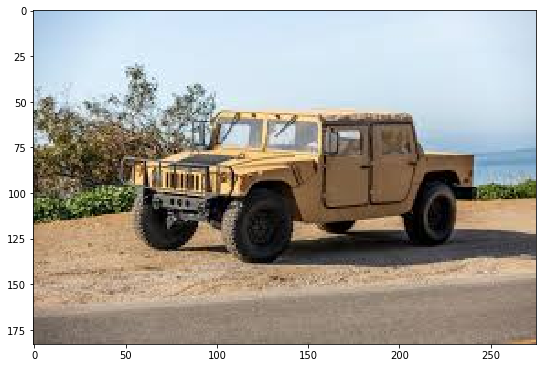

In [30]:
image_path = './Sample_images/hummer.jpeg'

image_bgr = cv.imread(image_path)
image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB) 
# Get its width and height
(im_width, im_height, _) = image.shape

# Get its np representation

plt.figure(figsize=(9,12))
plt.imshow(image_rgb)

In [31]:
bb, pbb = predict_bounding_box(image_rgb)

In [32]:
def calculate_area(bounding_box):
    ymin,xmin, ymax,xmax = bounding_box
    area = (ymax - ymin)*(xmax - xmin)
    return area

In [33]:
calculate_area(bb)

0.302651

In [34]:
image_rgb_with_bb= insert_bounding_box(image_rgb, bb)

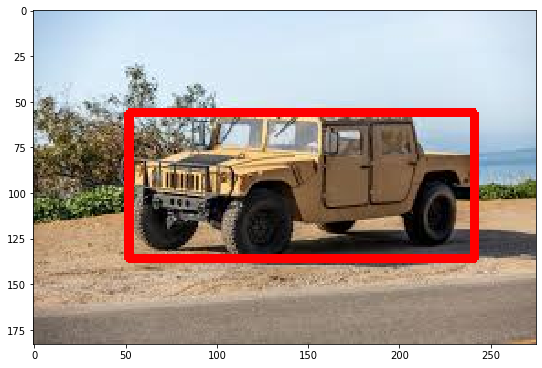

In [35]:
plt.figure(figsize=(9,12))
plt.imshow(image_rgb_with_bb)

In [ ]:
def crop_image_with_bounding_box(image_np,
                        bounding_box_coordinates,
                        color=(0,0,255),
                        thickness=3,
                        use_normalized_coordinates=True):
    """
    Function:
        - Adds a bounding box to the numpy representation of an image.
        - The bounding box coordinates can be specified in either absolute (pixel) or normalized coordinates.

    Arguments:
        - image_np (nd_array): a numpy representation of the image
        - bounding_box_coordinates (tuple): a tuple containing (ymin, xmin, ymax, xmax) of the bounding box.
        - color (str): string representation of the color of the bounding box. Default is 'red'.
        - thickness (int): line thickness of the bounding box. Default value is 4.
        - use_normalized_coordinates (bool): If True (default), treat coordinates as relative to the image dimension.  Otherwise treat
          coordinates as absolute.
    """

    # Get its width and height
    (im_height, im_width, _) = image_np.shape

    # Unpack the coordinates
    ymin,xmin,ymax,xmax = bounding_box_coordinates

    # Get the borders of the bounding box
    if use_normalized_coordinates:
        (xmin,xmax,ymin,ymax) = (int(xmin * im_width), int(xmax * im_width), int(ymin * im_height), int(ymax * im_height))
   
    #print(ymin,xmin,ymax,xmax)
    
    cropped_img_np = image_np[ymin:ymax, xmin: xmax]
    """
    cv.rectangle(img = image_np, 
                                            pt1 = (xmin, ymin), 
                                            pt2 = (xmax, ymax),
                                            
                                            color = color, 
                                            thickness = thickness)
    """
    # Return the modified np representation of the image into which the bounding box has been drawn
    return cropped_img_np

In [ ]:
Vans = ["GMC Canyon Extended Cab 2012","Mercedes-Benz Sprinter Van 2012","Ford Expedition EL SUV 2009", "Chevrolet TrailBlazer SS 2009", "Chevrolet Alavanche Crew Cab 2012", "Buick Rainier SUV 2007", "Cadillac Escalade EXT Crew Cab 2007"]

In [ ]:
for van in Vans:
    image_directory = "./data_unprocessed/" + van
    image_directory2 = "./data_cropped/"

    if not os.path.exists(image_directory2):
        os.mkdir(image_directory2)


    for root, directories, files in tqdm(os.walk(image_directory, topdown=False)):

        for i, file in tqdm(enumerate(files)):
            source_path = os.path.join(root, file)
            car_class = source_path.split(os.path.sep)[-2]
            print(car_class, i)
            destination_path = os.path.join(image_directory2,car_class, file)
            if os.path.exists(destination_path):
                print(f"{destination_path} already exists")
            else:
                try:
                    original_image_bgr = cv.imread(source_path)
                    original_image_rgb = cv.cvtColor(original_image_bgr, cv.COLOR_BGR2RGB)

                    best_bounding_box_coordinates, best_bounding_box_probability = predict_bounding_box(original_image_rgb)
                    if best_bounding_box_probability is not None and calculate_area(best_bounding_box_coordinates) > 0.1:
                        cropped_image_rgb = crop_image_with_bounding_box(original_image_rgb, best_bounding_box_coordinates)
                        cropped_image_bgr = cv.cvtColor(cropped_image_rgb, cv.COLOR_RGB2BGR)
                        destination_folder = os.path.join(image_directory2,car_class)
                        if not os.path.exists(destination_folder):
                            os.mkdir(destination_folder)
                        print(destination_path)
                        cv.imwrite(destination_path, cropped_image_bgr)
                except:
                    continue

            



for file_path in tqdm(all_files):
    pil_image = Image.open(file_path)
    np_image = np.asarray(pil_image)
    best_bounding_box_coordinates, best_bounding_box_probability = predict_bounding_box(np_image)
    if best_bounding_box_probability > 0.5:
        cropped_
    break
        

In [ ]:
def detect_car_and_crop(folder)